In [4]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from urllib.parse import quote

import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert

from datetime import datetime, timedelta

import numpy as np
import statistics
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

#마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [5]:
movie_df = pd.read_excel('./data/완_기간별_일별_170101_to_230509_ver2.xlsx')
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,너의 이름은.,2017-01-04,일본,일본,NaN,플러스엠 엔터테인먼트,12세이상관람가,"애니메이션,드라마,멜로/로맨스",신카이 마코토,...,2809088900,9745292442,333008,1182465,947,4101,2017,1,2017,1
1,3,모아나,2017-01-12,미국,미국,NaN,월트디즈니컴퍼니코리아 유한책임회사,전체관람가,애니메이션,"론 클레멘츠,존 머스커",...,7738000,9712000,910,1192,6,6,2017,1,2017,1
2,4,패신저스,2017-01-04,미국,미국,NaN,유니버설픽쳐스인터내셔널 코리아(유),12세이상관람가,"어드벤처,SF",모튼 틸덤,...,1107502600,4176443418,129810,504393,608,2272,2017,1,2017,1
3,9,눈의 여왕 3: 눈과 불의 마법대결,2017-01-04,러시아,러시아,NaN,(주)이수C&E,전체관람가,"애니메이션,어드벤처,가족,판타지",알렉세이 트시칠린,...,535436000,1828596400,67605,242171,524,1163,2017,1,2017,1
4,10,사랑하기 때문에,2017-01-04,한국,한국,(주)에이디사공육,(주)넥스트엔터테인먼트월드(NEW),12세이상관람가,"코미디,멜로/로맨스",주지홍,...,450612400,1968850940,53856,246167,542,1533,2017,1,2017,1


# 상관관계

In [5]:
movie_df_corr = movie_df[['매출액', '누적매출액', '관객수', '누적관객수', '스크린수', '상영횟수']]
corr_df = movie_df_corr.corr()
corr_df

,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수
매출액,1.000000,0.190272,0.993342,0.189412,0.698389,0.792487
누적매출액,0.190272,1.000000,0.188367,0.992949,0.252035,0.229867
관객수,0.993342,0.188367,1.000000,0.190428,0.695585,0.792454
누적관객수,0.189412,0.992949,0.190428,1.000000,0.246365,0.227040
스크린수,0.698389,0.252035,0.695585,0.246365,1.000000,0.954058
상영횟수,0.792487,0.229867,0.792454,0.227040,0.954058,1.000000


<Axes: >

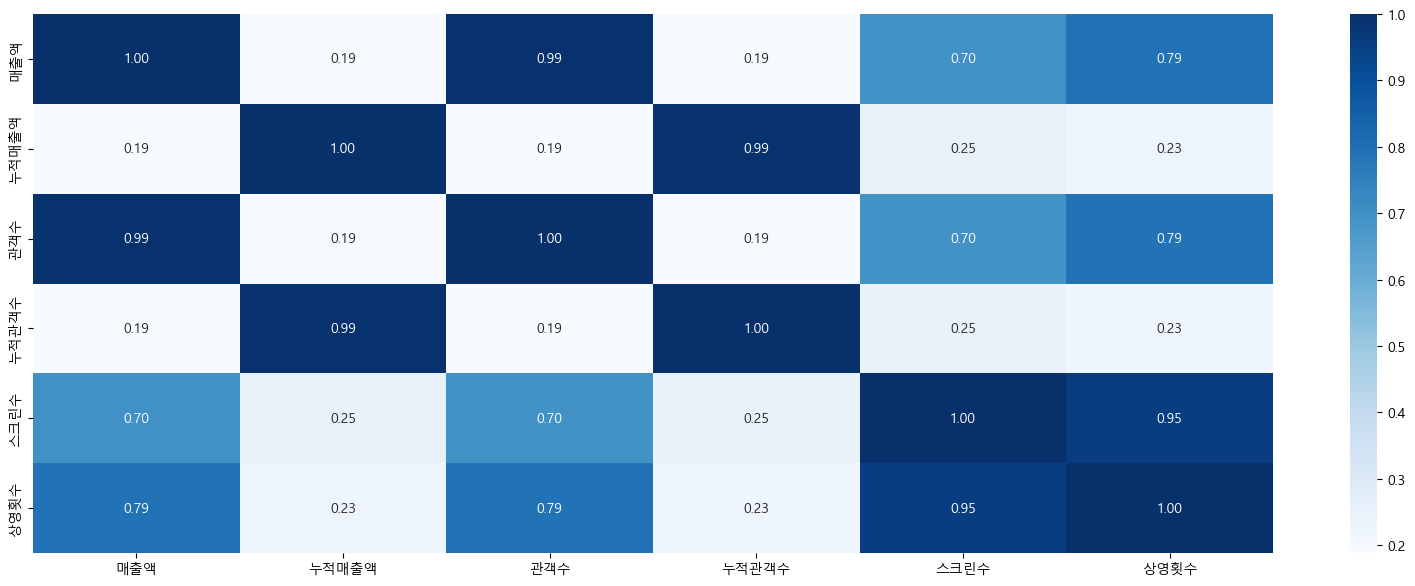

In [6]:
plt.figure(figsize=(20,7))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="Blues")

# 매출 변화

In [6]:
movie_info = movie_df[['영화명','개봉일','대표국적','등급','기준일','매출액','누적매출액','관객수','누적관객수','스크린수','상영횟수','기준연도','기준월','개봉연도','개봉월']]
movie_info_2023 = movie_info[movie_info['기준연도']==2023]
movie_info = movie_info[(movie_info['기준연도']!=2023)&(movie_info['기준연도']!=2017)]
movie_info.head(3)

,영화명,개봉일,대표국적,등급,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
666,국가부도의 날,2018-11-28,한국,12세이상관람가,2018-12-02,3542110050,12758179511,400083,1571881,1152,6166,2018,12,2018,11
667,보헤미안 랩소디,2018-10-31,미국,12세이상관람가,2018-12-02,2642813900,52692975273,292238,6046948,1103,4706,2018,12,2018,10
668,성난황소,2018-11-22,한국,15세이상관람가,2018-12-02,720162200,12156145437,82221,1451665,633,2086,2018,12,2018,11


In [6]:
movie_year_info = movie_info.groupby(['기준연도']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_info

,매출액,관객수,스크린수,상영횟수
기준연도,,,,
2018,1803723964724,214885747,2048592,6486492
2019,1905789216740,225349152,2202753,6819164
2020,499808908001,57991480,1699998,4230505
2021,575737892070,59492547,1915754,4550575
2022,1156311591025,112287221,2085868,5653085


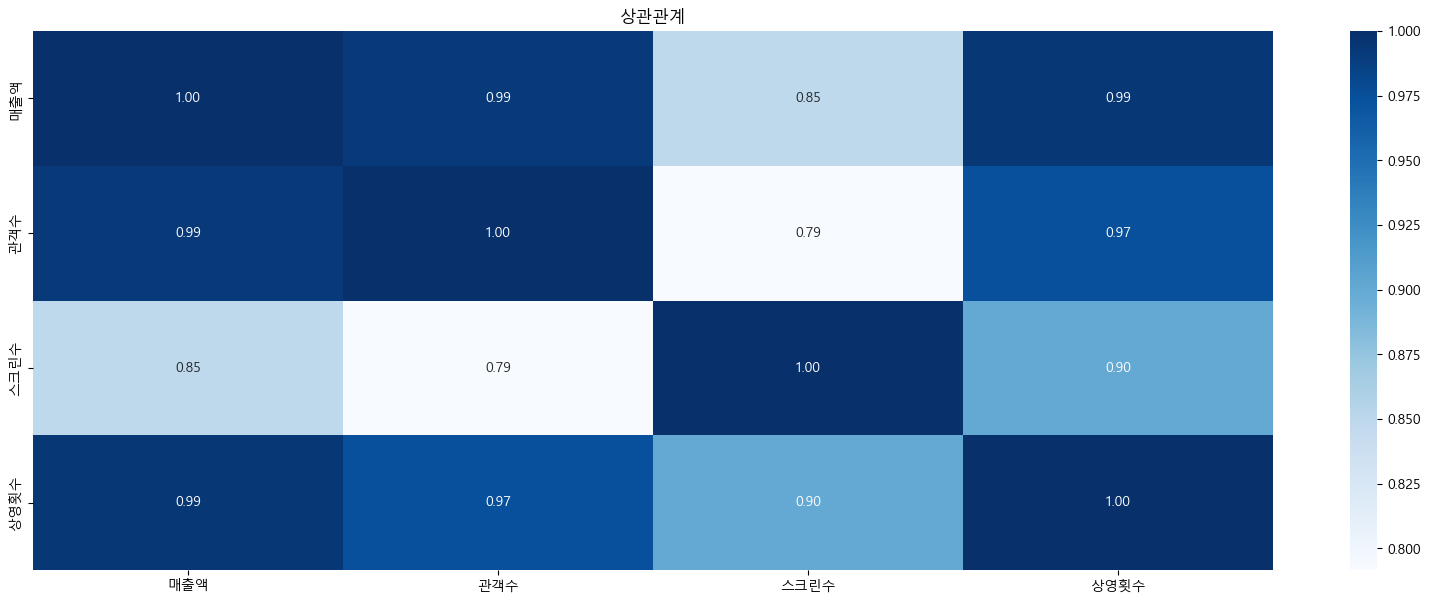

In [10]:
plt.figure(figsize=(20,7))
sns.heatmap(movie_year_info.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("상관관계")
plt.show()

In [11]:
movie_year_info['매출액']

기준연도
2018    1803723964724
2019    1905789216740
2020     499808908001
2021     575737892070
2022    1156311591025
Name: 매출액, dtype: int64

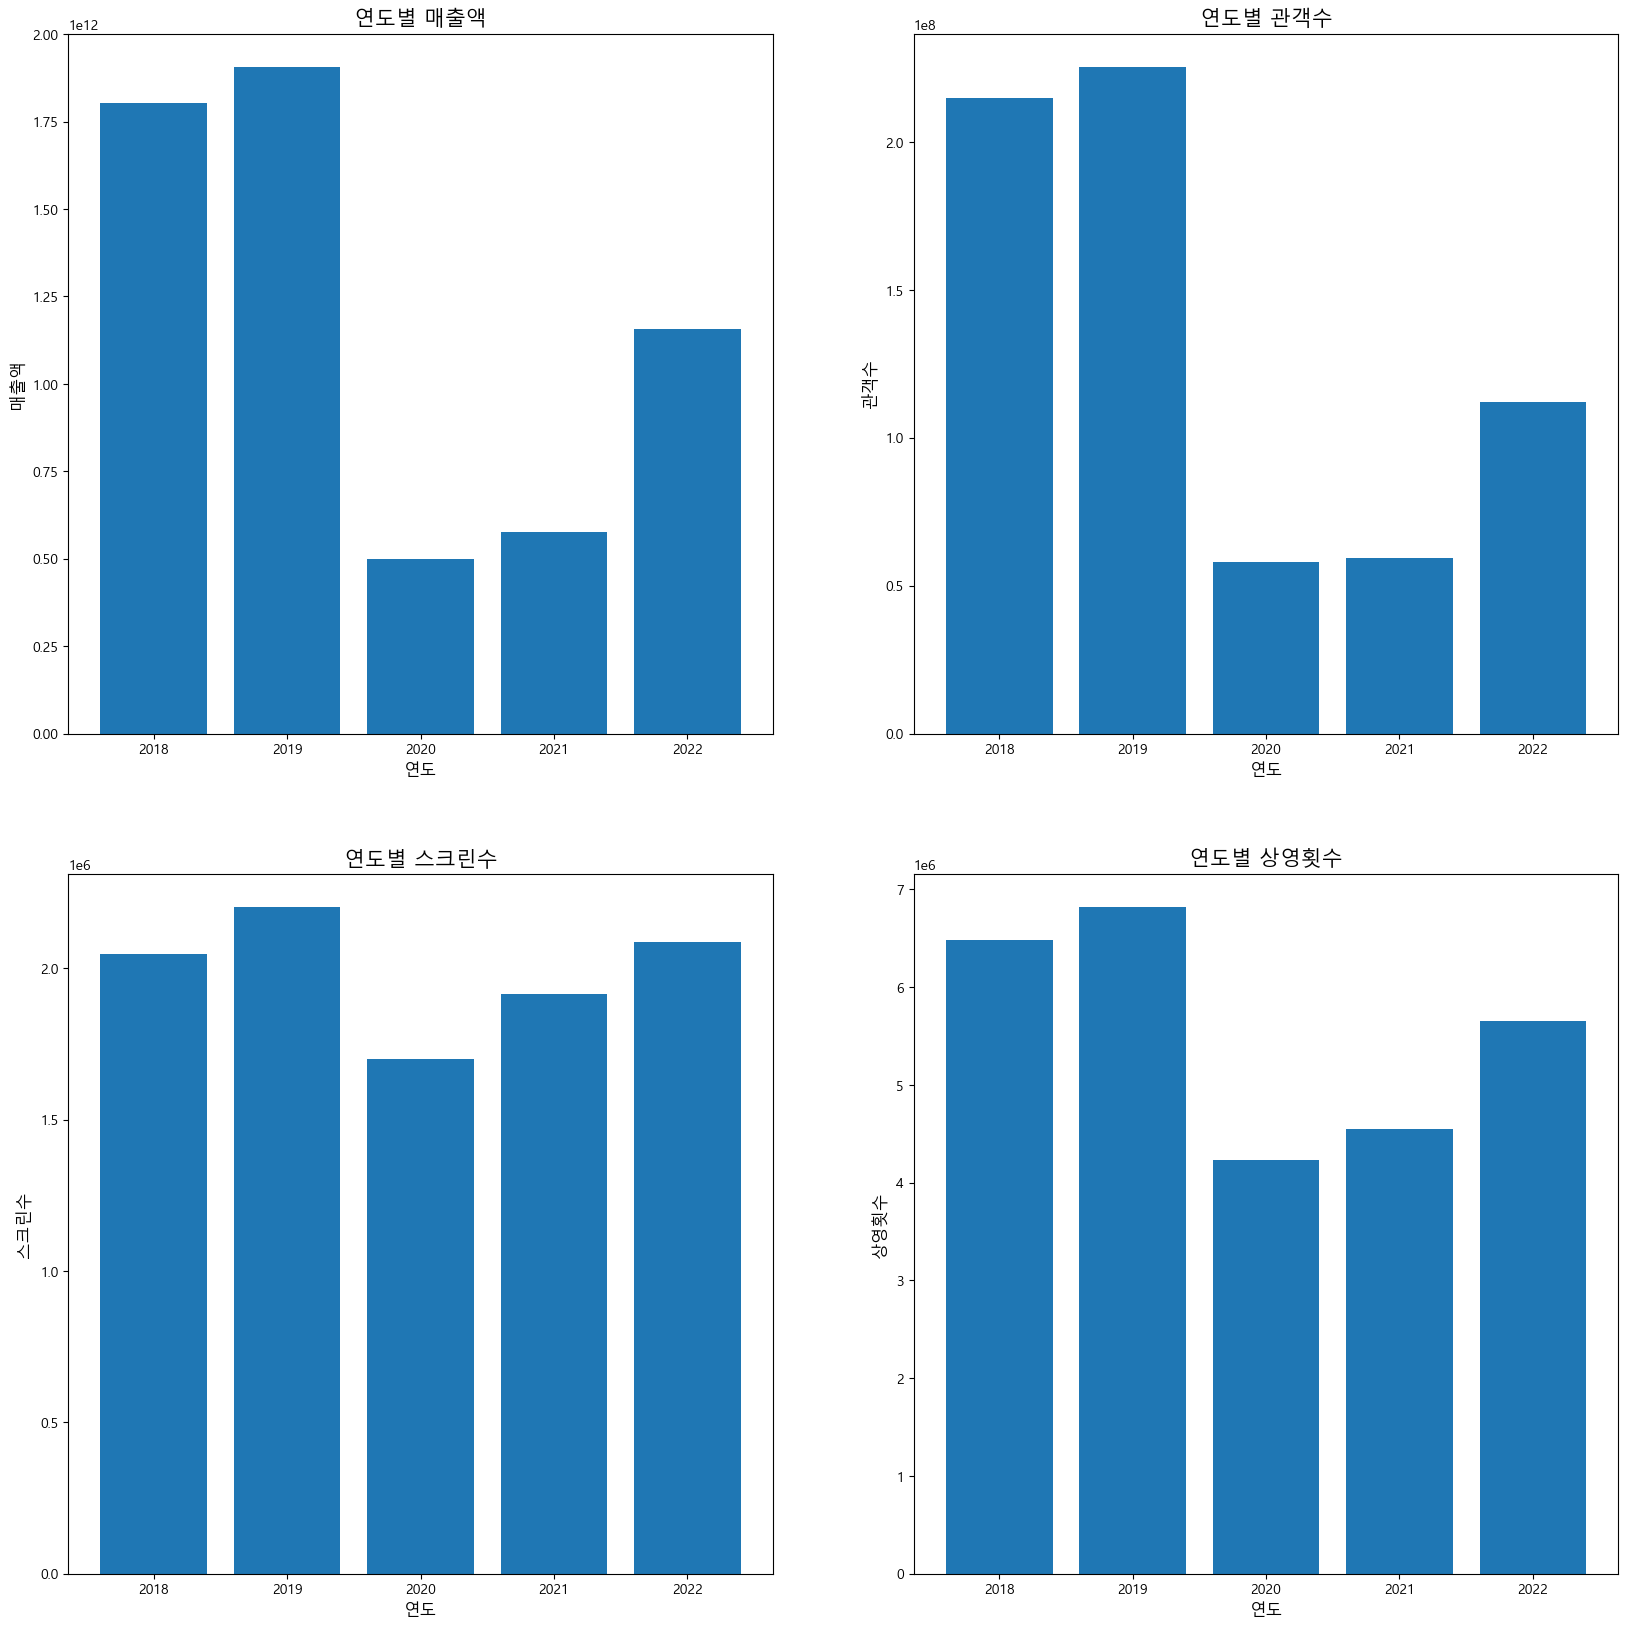

In [12]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax1.bar(movie_year_info['매출액'].index, movie_year_info['매출액'].values)

ax1.set_title('연도별 매출액', size=15)
ax1.set_xlabel('연도',size=12)
ax1.set_ylabel('매출액',size=12)

ax2 = fig.add_subplot(2,2,2)
ax2.bar(movie_year_info['관객수'].index, movie_year_info['관객수'].values)

ax2.set_title('연도별 관객수', size=15)
ax2.set_xlabel('연도',size=12)
ax2.set_ylabel('관객수',size=12)

ax3 = fig.add_subplot(2,2,3)
ax3.bar(movie_year_info['스크린수'].index, movie_year_info['스크린수'].values)

ax3.set_title('연도별 스크린수', size=15)
ax3.set_xlabel('연도',size=12)
ax3.set_ylabel('스크린수',size=12)

ax4 = fig.add_subplot(2,2,4)
ax4.bar(movie_year_info['상영횟수'].index, movie_year_info['상영횟수'].values)

ax4.set_title('연도별 상영횟수', size=15)
ax4.set_xlabel('연도',size=12)
ax4.set_ylabel('상영횟수',size=12)

plt.show()

In [13]:
movie_year_info

,매출액,관객수,스크린수,상영횟수
기준연도,,,,
2018,1803723964724,214885747,2048592,6486492
2019,1905789216740,225349152,2202753,6819164
2020,499808908001,57991480,1699998,4230505
2021,575737892070,59492547,1915754,4550575
2022,1156311591025,112287221,2085868,5653085


In [ ]:
# 총매출이 줄었다는것 = 관객수가 줄었다

In [ ]:
# 4월에 매출이 작고 8월에 가장큼 - 장르 비교?
# 그 분기에 가장 많이 성공한 영화?
# 개봉한 영화?
# 개봉후 첫 주말
# 2023.05 63819008412
# 2023.04 70688545576

In [7]:
movie_year_month_info = movie_info.groupby(['기준연도','기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_month_info

매출액       관객수    스크린수    상영횟수
기준연도 기준월                                        
2018 1    182593762055  22857721  178788  540841
     2    125579520604  15419813  167972  498138
     3    103249323080  12712970  170235  540030
     4    119012960079  13965675  165383  522102
     5    138605331723  15841704  158730  524425
     6    130064967730  15008178  157345  521916
     7    165197657758  19628365  164974  558527
     8    251512854720  30118734  180439  573368
     9    143012861199  16696748  169638  559190
     10   117865966879  13846507  171076  558142
     11   143404452827  16956968  165535  520896
     12   183624306070  21832364  198477  568917
2019 1    150642517096  18039197  207056  571816
     2    188837781100  22117219  169482  540452
     3    126063124169  14587859  178920  559610
     4    112558822860  13240782  173459  501753
     5    154084279784  17980182  169653  539657
     6    193410126770  22592502  166170  547142
     7    183471335654  21808456  185621  594051
     8    208508949348  24695242  204292  631832
     9    123735469044  14609600  187985  557225
     10   123289112660  14770364  179838  577520
     11   154985048555  18522069  179798  585253
     12   186202649700  22385680  200479  612853
2020 1    143241268330  16764628  199312  605259
     2     61288986040   7243587  157385  487750
     3     13751384050   1608481  118522  236289
     4      6464392100    785177   80585  129337
     5     11757677380   1421263  133759  217167
     6     31729156620   3719875  133610  327257
     7     45893449550   5432258  145525  415831
     8     76331690039   8722077  154987  488045
     9     25671740652   2936220  136966  342298
     10    41120417960   4573624  166234  398591
     11    31057749810   3451711  141265  347968
     12    11500995470   1332579  131848  234713
2021 1     14757173490   1663695  109773  198686
     2     27326517230   2956945  133918  289057
     3     28195246720   3065133  148733  307110
     4     23211632320   2516203  154361  322626
     5     40156952120   4268374  171067  358469
     6     46785738940   4895030  158022  400910
     7     68001647640   6920842  174413  455929
     8     76171187340   7877177  171789  482177
     9     51238098193   5299796  175481  430963
     10    50330854130   5124020  170643  427250
     11    65516259119   6458853  171101  453664
     12    84046584828   8446479  176453  423734
2022 1     55494540020   5698426  173492  442932
     2     30636350090   3230627  153760  365712
     3     26844822720   2772014  161925  364243
     4     30076613310   3073924  159226  379532
     5    150418376910  14509939  159775  528386
     6    158009480790  15450430  156024  522306
     7    170096315665  16231138  185465  564496
     8    152130983750  14926619  196769  565202
     9    101645205347   9824043  174162  496599
     10    60914620218   6126650  200226  491663
     11    63163069397   6337508  173141  447516
     12   156881212808  14105903  191903  484498

In [8]:
movie_month_info = movie_info.groupby(['기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_month_info

,매출액,관객수,스크린수,상영횟수
기준월,,,,
1,546729260991,65023667,868421,2359534
2,433669155064,50968191,782517,2181109
3,298103900739,34746457,778335,2007282
4,291324420669,33581761,733014,1855350
5,495022617917,54021462,792984,2168104
6,559999470850,61666015,771171,2319531
7,632660406267,70021059,855998,2588834
8,764655665197,86339849,908276,2740624
9,445303374435,49366407,844232,2386275


In [9]:
movie_year_month_info_2023 = movie_info_2023.groupby(['기준연도','기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_month_info_2023[:-1]

매출액       관객수    스크린수    상영횟수
기준연도 기준월                                        
2023 1    123808074711  11220380  207405  525120
     2     62335465454   5942445  186764  427956
     3     79804374946   7445640  190480  465873
     4     69957651381   6902721  174795  437812

In [25]:
movie_year_month_info.loc[2022]['매출액']

기준월
1      55494540020
2      30636350090
3      26844822720
4      30076613310
5     150418376910
6     158009480790
7     170096315665
8     152130983750
9     101645205347
10     60914620218
11     63163069397
12    156881212808
Name: 매출액, dtype: int64

In [9]:
month_list = movie_year_month_info.loc[2022]['매출액'].index.map(lambda x: str(x)).to_list()
month_list

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

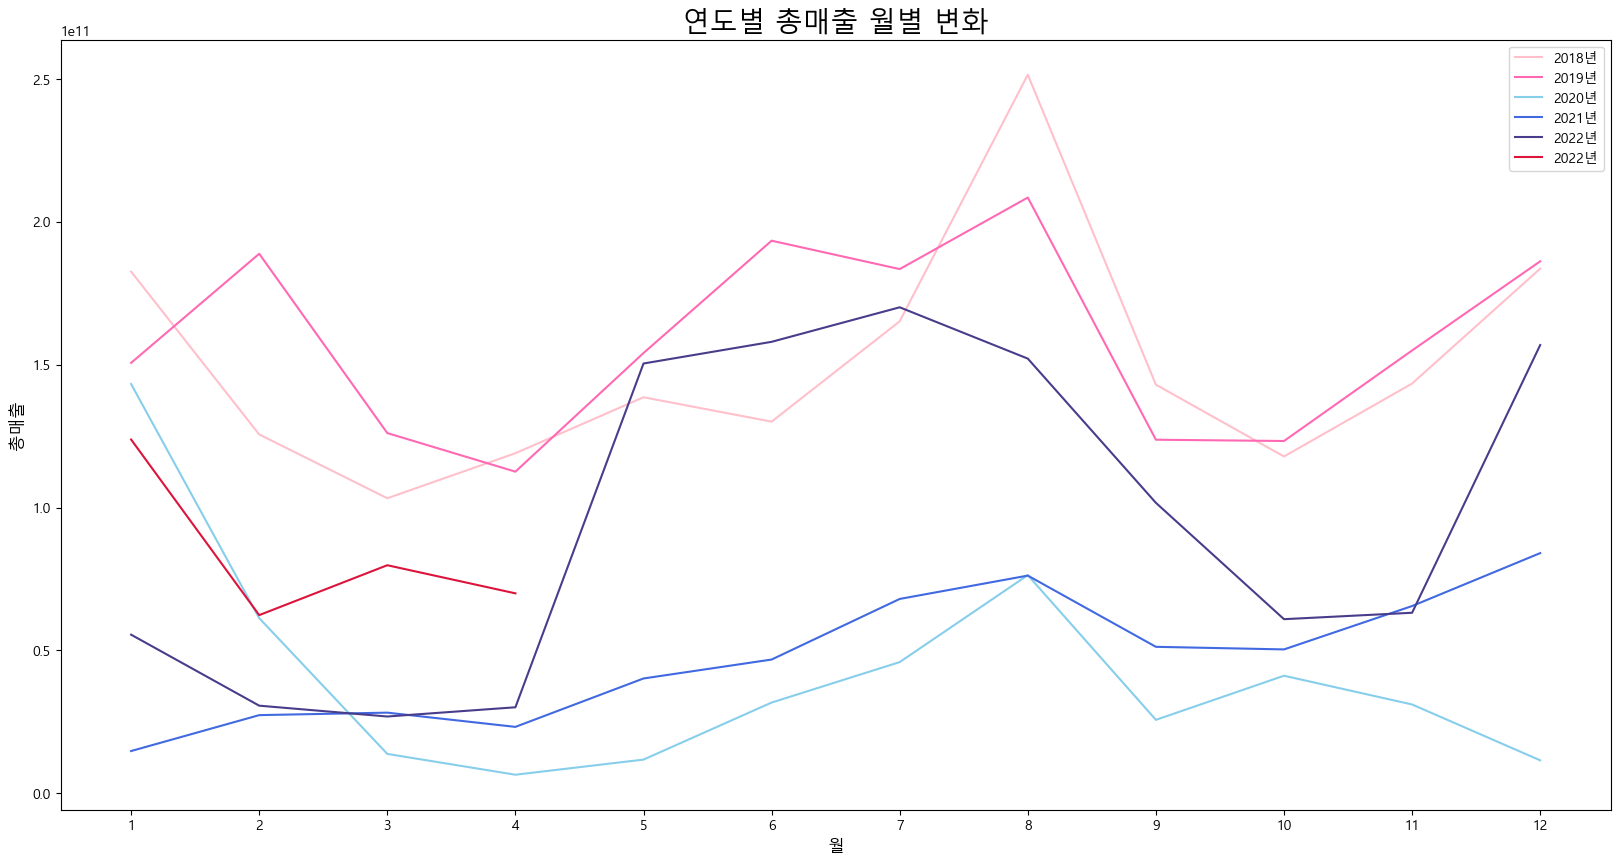

In [69]:
# 연도별 월별 총매출 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

month_list = movie_year_month_info.loc[2022]['매출액'].index.map(lambda x: str(x)).to_list()

ax.plot(month_list,movie_year_month_info.loc[2018]['매출액'], color="pink", label="2018년")
ax.plot(month_list,movie_year_month_info.loc[2019]['매출액'], color="hotpink", label="2019년")
ax.plot(month_list,movie_year_month_info.loc[2020]['매출액'], color="skyblue", label="2020년")
ax.plot(month_list,movie_year_month_info.loc[2021]['매출액'], color="royalblue", label="2021년")
ax.plot(month_list,movie_year_month_info.loc[2022]['매출액'], color="darkslateblue", label="2022년")
ax.plot(month_list[:4],movie_year_month_info_2023[:-1].loc[2023]['매출액'], color="crimson", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 총매출 월별 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('총매출',size=12)
plt.show()

In [ ]:
# 월별로 어떤 영화의 매출이 가장 높았는가?


In [10]:
month_movie_sales = movie_info.groupby(["영화명","개봉일","기준연도","기준월"])["매출액"].sum().to_frame()
month_movie_sales = month_movie_sales.reset_index().set_index("영화명")
month_movie_sales

,개봉일,기준연도,기준월,매출액
영화명,,,,
#살아있다,2020-06-24,2020,6,9956085460
#살아있다,2020-06-24,2020,7,5979662060
#살아있다,2020-06-24,2020,8,29582380
#살아있다,2020-06-24,2020,10,2890000
#아이엠히어,2021-01-14,2021,1,135795710
...,...,...,...,...
"힘을 내요, 미스터 리",2019-09-11,2019,9,9806144806
"힘을 내요, 미스터 리",2019-09-11,2019,10,65009600
"힘을 내요, 미스터 리",2019-09-11,2019,11,5759500


# 매출 발생이 가장 높은달(8월)과 낮은달(4월) 비교

In [11]:
April_sales_movie = month_movie_sales[month_movie_sales["기준월"]==4]
August_sales_movie = month_movie_sales[month_movie_sales["기준월"]==8]
April_sales_movie = April_sales_movie.sort_values(["매출액"],axis=0, ascending=False)
August_sales_movie = August_sales_movie.sort_values(["매출액"],axis=0, ascending=False)

In [12]:
April_sales_movie_top = April_sales_movie[April_sales_movie['매출액']>5000000].reset_index()
August_sales_movie_top = August_sales_movie[August_sales_movie['매출액']>5000000].reset_index()

In [13]:
April_sales_movie_top

,영화명,개봉일,기준연도,기준월,매출액
0,어벤져스: 엔드게임,2019-04-24,2019,4,63197528530
1,어벤져스: 인피니티 워,2018-04-25,2018,4,46128544531
2,레디 플레이어 원,2018-03-28,2018,4,13863899642
3,곤지암,2018-03-28,2018,4,13733316070
4,램페이지,2018-04-12,2018,4,11895097696
...,...,...,...,...,...
434,인생 후르츠,2018-12-06,2019,4,5169000
435,누구나 아는 비밀,2019-08-01,2019,4,5147000
436,도우터 오브 마인,2019-04-25,2019,4,5142360
437,사바하,2019-02-20,2019,4,5066300


In [13]:
merge_df = movie_df[["영화명","장르"]].drop_duplicates()
merge_df

,영화명,장르
0,너의 이름은.,"애니메이션,드라마,멜로/로맨스"
1,모아나,애니메이션
2,패신저스,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,"코미디,멜로/로맨스"
...,...,...
182989,내 아내의 불륜,"멜로/로맨스,드라마"
182990,리벤지포르노 페인트 잇 블랙,"멜로/로맨스,드라마"
182991,밀애: 시아버지,"멜로/로맨스,드라마"
182992,옆집 여자: 처음엔 거부 나증엔 신음,"멜로/로맨스,드라마"


In [14]:
April_top = pd.merge(April_sales_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')
August_top = pd.merge(August_sales_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')

In [15]:
movie_genre = movie_df[['영화명','개봉일','기준연도','기준월','매출액','관객수','장르']].copy()
movie_genre.dropna(subset=["장르"],inplace=True)

In [16]:
genre = []
for li in movie_genre['장르'].unique():
    if ',' in li:
        pass
    else:
        genre.append(li)
len(genre)

21

In [17]:
# 장르별 컬럼 만들기
for col in genre:
    April_top[col]=0
    August_top[col]=0
    
April_top.head(3)
August_top.head(3)

,영화명,개봉일,기준연도,기준월,매출액,장르,애니메이션,드라마,공포(호러),액션,...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,신과함께-인과 연,2018-08-01,2018,8,100553061209,"판타지,드라마",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,엑시트,2019-07-31,2019,8,70494628112,"코미디,액션",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,한산: 용의 출현,2022-07-27,2022,8,48640449693,"액션,드라마",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
for col in genre:
    April_top[col]=April_top["장르"].apply(lambda x: 1 if col in x else 0)
    August_top[col]=August_top["장르"].apply(lambda x: 1 if col in x else 0)

In [20]:
April_top.head(2)

,영화명,개봉일,기준연도,기준월,매출액,장르,애니메이션,드라마,공포(호러),액션,...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,어벤져스: 엔드게임,2019-04-24,2019,4,63197528530,"액션,SF",0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,어벤져스: 인피니티 워,2018-04-25,2018,4,46128544531,"액션,어드벤처,판타지,SF",0,0,0,1,...,1,0,0,1,0,0,0,0,0,0


In [31]:
April_genre_df = April_top.iloc[:,6:]
April_total_genre = April_genre_df.sum(axis=0)
April_total_genre.sort_values(ascending=False, inplace=True)
April_total_genre_df = April_total_genre[:10]
April_total_genre_df['others'] = April_total_genre[10:].sum(axis=0)

August_genre_df = August_top.iloc[:,6:]
August_total_genre = August_genre_df.sum(axis=0)
August_total_genre.sort_values(ascending=False, inplace=True)
August_total_genre_df = August_total_genre[:10]
August_total_genre_df['others'] = August_total_genre[10:].sum(axis=0)

In [33]:
len(April_total_genre_df)

11

In [34]:
# 색상 맵 선택
cmap = cm.get_cmap('tab20c')
colors = cmap(np.array(range(1,50)))

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_9728\1826526935.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


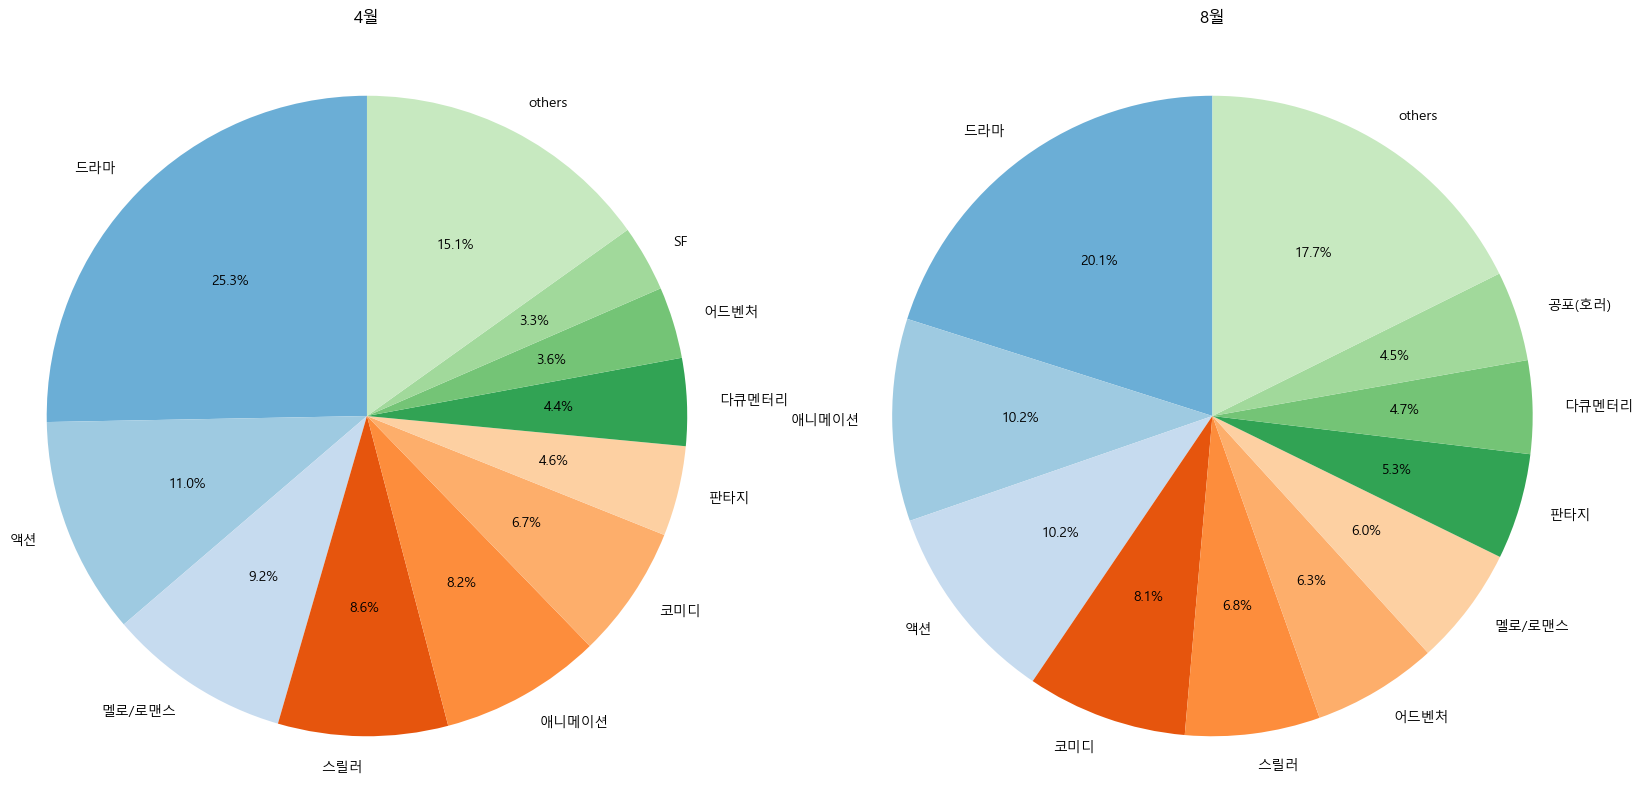

In [36]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.pie(April_total_genre_df.values.flatten(), labels=April_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax2.pie(August_total_genre_df.values.flatten(), labels=August_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax1.set_title('4월')
ax1.axis('equal')
ax2.set_title('8월')
ax2.axis('equal')

plt.show()

# 4월과 8월에 개봉한 영화 장르

In [37]:
open_movie = movie_df[['영화명','개봉연도','개봉월','매출액','장르']].copy()
open_movie.dropna(subset=["장르"],inplace=True)
open_movie.drop_duplicates(inplace=True)
open_movie

,영화명,개봉연도,개봉월,매출액,장르
0,너의 이름은.,2017,1,2809088900,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,7738000,애니메이션
2,패신저스,2017,1,1107502600,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,450612400,"코미디,멜로/로맨스"
...,...,...,...,...,...
183000,"내 어깨 위 고양이, 밥",2017,1,32837000,드라마
183001,돈 지오반니,2017,1,4881000,공연
183002,걱정말아요,2017,1,502000,드라마
183003,비밀객잔의 결투,2017,1,7000,"액션,어드벤처,드라마"


In [38]:
open_movie_df = open_movie.groupby(["영화명","개봉연도","개봉월"])["매출액"].sum().to_frame().reset_index().set_index('영화명')
open_movie_df = open_movie_df[(open_movie_df["개봉연도"]!=2017)&(open_movie_df["개봉연도"]!=2023)]
open_movie_df

,개봉연도,개봉월,매출액
영화명,,,
#살아있다,2020,6,15968190400
#아이엠히어,2021,1,136875710
#위왓치유,2021,6,15868950
#해시태그,2022,6,2205600
0.0MHz,2019,5,1088253860
...,...,...,...
힐링하우스 : 섹스의 왕국,2022,5,6000
힐빌리의 노래,2020,11,33965080
힘 좋은 시아버지와 착한 며느리,2021,3,100000


In [39]:
April_open_movie = open_movie_df[open_movie_df["개봉월"]==4]
August_open_movie = open_movie_df[open_movie_df["개봉월"]==8]
April_open_movie = April_open_movie.sort_values(["매출액"],axis=0, ascending=False)
August_open_movie = August_open_movie.sort_values(["매출액"],axis=0, ascending=False)

In [40]:
April_open_movie_top = April_open_movie[April_open_movie['매출액']>1000000]
August_open_movie_top = August_open_movie[August_open_movie['매출액']>1000000]

In [41]:
April_open_top = pd.merge(April_open_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')
August_open_top = pd.merge(August_open_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')

In [42]:
# 장르별 컬럼 만들기
for col in genre:
    April_open_top[col]=0
    August_open_top[col]=0
    
April_open_top.head(3)
August_open_top.head(3)

,영화명,개봉연도,개봉월,매출액,장르,애니메이션,드라마,공포(호러),액션,다큐멘터리,...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,신과함께-인과 연,2018,8,102689023539,"판타지,드라마",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,헌트,2022,8,44599068153,"액션,공포(호러),스릴러",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,헌트,2022,8,44599068153,"액션,드라마",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
for col in genre:
    April_open_top[col]=April_open_top["장르"].apply(lambda x: 1 if col in x else 0)
    August_open_top[col]=August_open_top["장르"].apply(lambda x: 1 if col in x else 0)

In [44]:
April_open_genre_df = April_open_top.iloc[:,6:]
April_open_total_genre = April_open_genre_df.sum(axis=0)
April_open_total_genre.sort_values(ascending=False, inplace=True)
April_open_total_genre_df = April_open_total_genre[:10]
April_open_total_genre_df['others'] = April_open_total_genre[10:].sum(axis=0)


August_open_genre_df = August_open_top.iloc[:,6:]
August_open_total_genre = August_open_genre_df.sum(axis=0)
August_open_total_genre.sort_values(ascending=False, inplace=True)
August_open_total_genre_df = August_open_total_genre[:10]
August_open_total_genre_df['others'] = August_open_total_genre[10:].sum(axis=0)

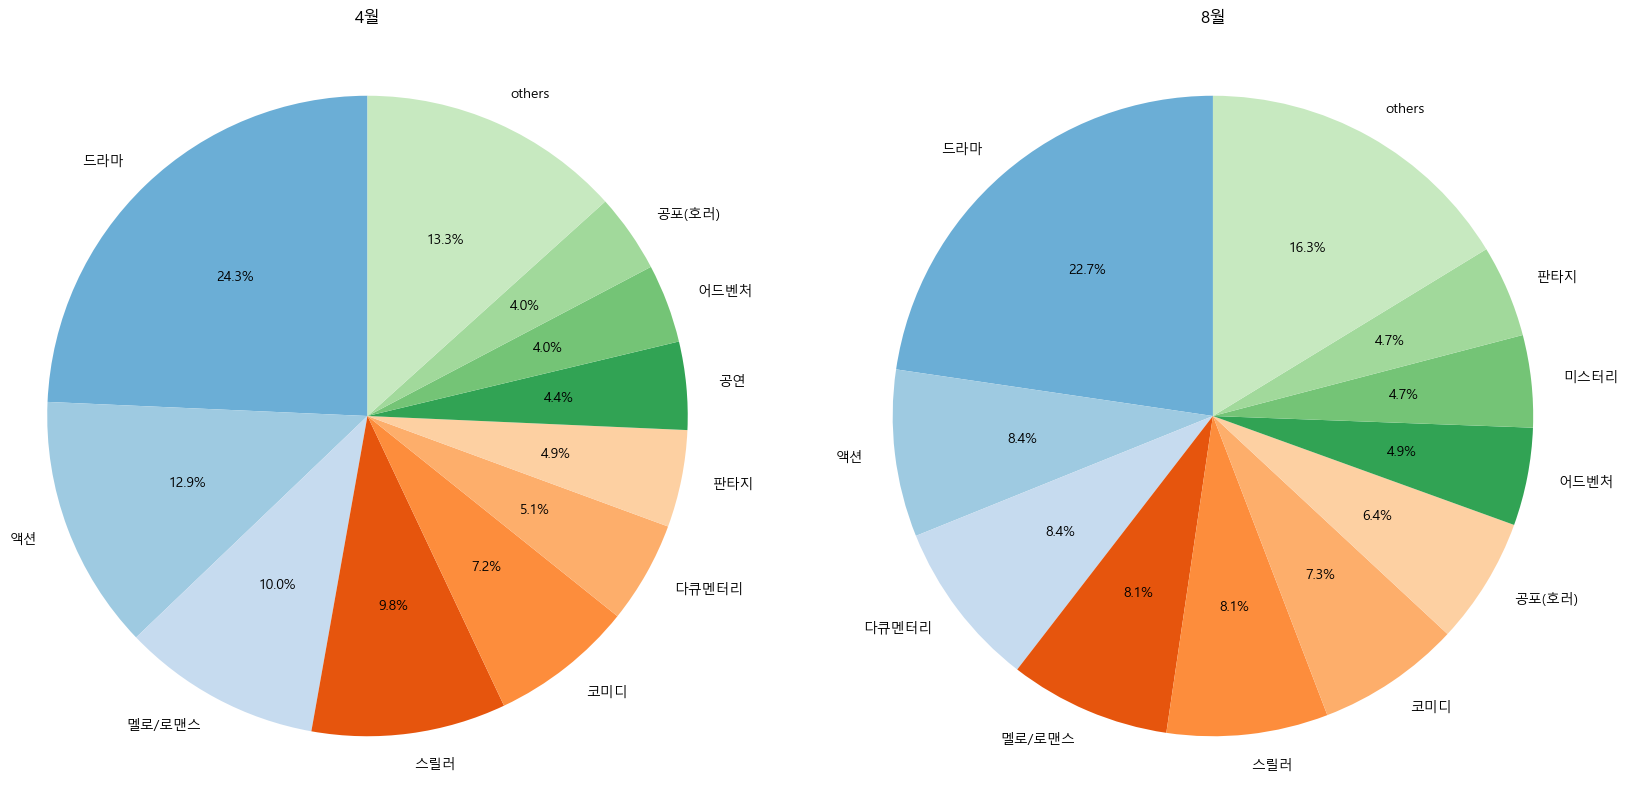

In [45]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.pie(April_open_total_genre_df.values.flatten(), labels=April_open_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax2.pie(August_open_total_genre_df.values.flatten(), labels=August_open_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax1.set_title('4월')
ax1.axis('equal')
ax2.set_title('8월')
ax2.axis('equal')

plt.show()

In [46]:
ani = month_movie_sales.copy()
ani = pd.merge(ani,merge_df,
               left_on = "영화명",right_on = "영화명", how='left')
ani.dropna(subset=["장르"],inplace=True)

for col in genre:
    ani[col] = 0
    
for col in genre:
    ani[col]=ani["장르"].apply(lambda x: 1 if col in x else 0)
    
ani = ani[ani['애니메이션']==1]

In [47]:
ani.sort_values(['매출액'],ascending=False, inplace =True)

In [51]:
ani[(ani['기준월']==8)&(ani['매출액']>100000000)].shape

(33, 27)

In [52]:
ani[(ani['기준월']==4)&(ani['매출액']>100000000)].shape

(15, 27)

# 월별 개봉한 영화 수 비교

In [41]:
month_movie_count = movie_df[['영화명', '개봉연도', '개봉월']]
month_movie_count = month_movie_count.drop_duplicates()
month_movie_count = month_movie_count.groupby(["개봉연도","개봉월"])["영화명"].count().to_frame().reset_index()
month_movie_count = month_movie_count[(month_movie_count['개봉연도']!=2017)&(month_movie_count['개봉연도']!=2023)]
month_movie_count = month_movie_count.set_index("개봉연도")
month_movie_count

,개봉월,영화명
개봉연도,,
2018,1,159
2018,2,126
2018,3,153
2018,4,145
2018,5,143
2018,6,133
2018,7,168
2018,8,156
2018,9,139


In [42]:
month_movie_count.loc[2022]['개봉월'].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

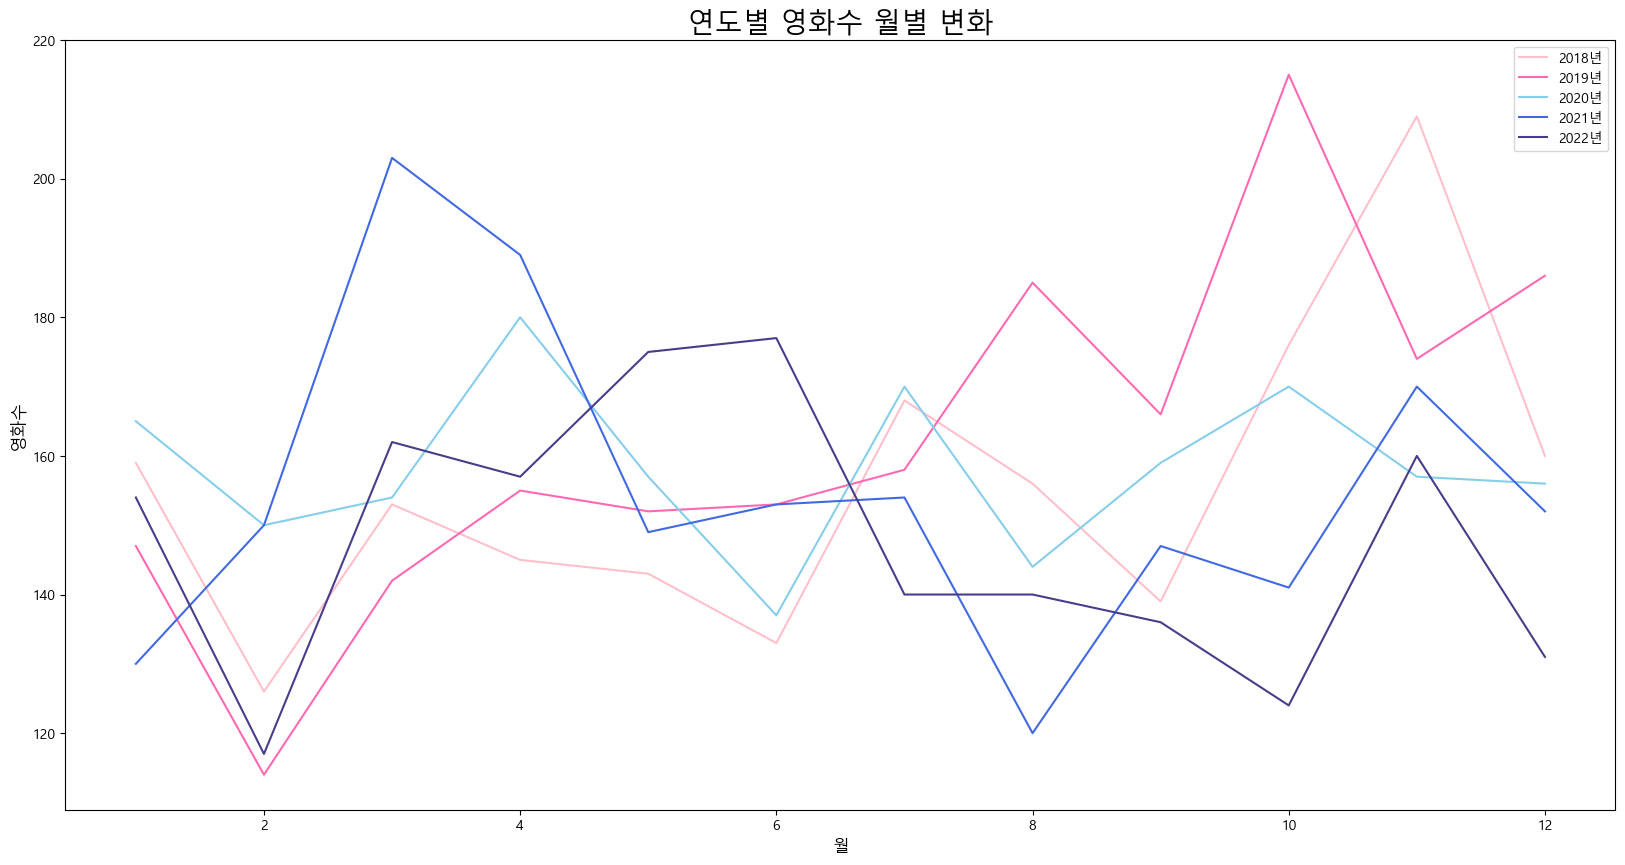

In [43]:
# 연도별 월별 영화명 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

month_list = month_movie_count.loc[2022]['개봉월'].values

ax.plot(month_list,month_movie_count.loc[2018]['영화명'], color="pink", label="2018년")
ax.plot(month_list,month_movie_count.loc[2019]['영화명'], color="hotpink", label="2019년")
ax.plot(month_list,month_movie_count.loc[2020]['영화명'], color="skyblue", label="2020년")
ax.plot(month_list,month_movie_count.loc[2021]['영화명'], color="royalblue", label="2021년")
ax.plot(month_list,month_movie_count.loc[2022]['영화명'], color="darkslateblue", label="2022년")
# ax.plot(month_list[:4],movie_year_month_info_2023[:-1].loc[2023]['매출액'], color="crimson", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 영화수 월별 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('영화수',size=12)
plt.show()

In [47]:
total_month_movie_count = month_movie_count.groupby(["개봉월"])['영화명'].sum().to_frame()
total_month_movie_count

,영화명
개봉월,
1,755
2,657
3,814
4,826
5,776
6,753
7,790
8,745
9,747


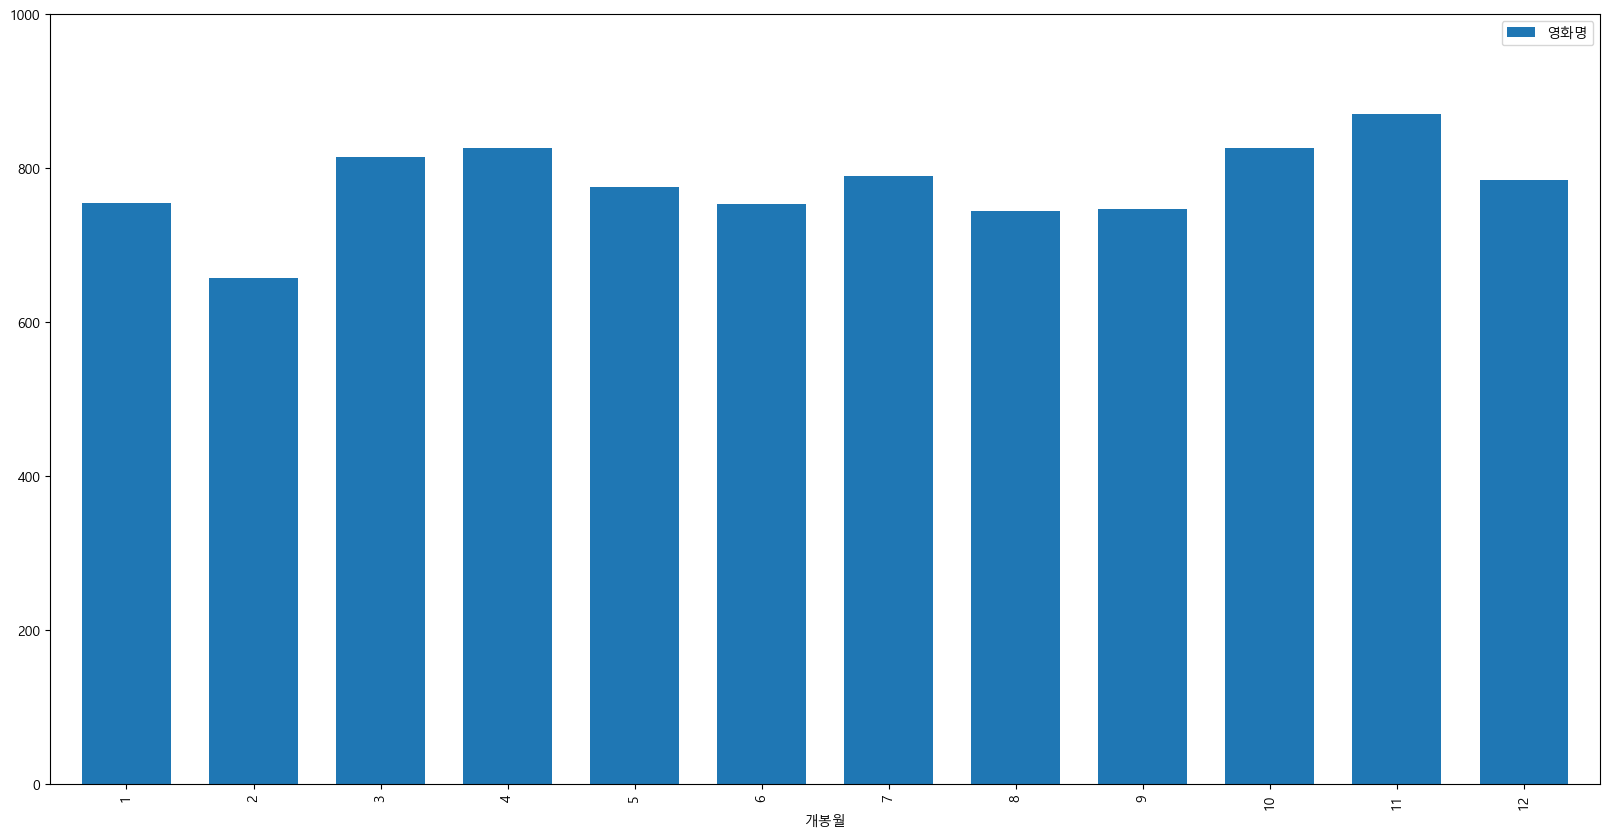

In [57]:
# 무작정 개봉하는것보다 관객의 수요를 파악하는것이 중요
# 개봉한 영화가 많다고해서 매출이 늘어나지 않음
total_month_movie_count.plot(kind='bar', figsize=(20,10), width=0.7)
plt.ylim(0,1000)
plt.show()